In [1]:
import pathlib
import pickle

import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import scipy.ndimage as scn
import scipy.interpolate as sci
import scipy.optimize as sco

from jax.config import config
import jax
import jax.numpy as jnp
import jax.scipy as jsci

import jax
import jax.numpy as jnp
from jax.scipy.special import logsumexp
from jax_cosmo.scipy.interpolate import InterpolatedUnivariateSpline

import numpyro
numpyro.enable_x64()
import numpyro.distributions as dist
from jax import lax, random
from jax.scipy.stats import poisson, norm
from numpyro.distributions import TruncatedNormal
from numpyro.infer import MCMC, NUTS, Predictive

from numpyro_ext.optim import optimize

In [2]:
from stream_membership import SplineDensityMixtureModel
from gd1_helpers.membership import GD1BackgroundModel, GD1StreamModel

In [3]:
gd1_tbl = at.Table.read("../data/tmp/gd1-gaiadr3-blog.fits")

# We will apply one additional selection criteria to limit the number of stars we have to handle:
gd1_tbl = gd1_tbl[(gd1_tbl["gd1_phi2"] > -7) & (gd1_tbl["gd1_phi2"] < 5)]

In [4]:
gd1_data = {
    "phi1": gd1_tbl["gd1_phi1"].astype(np.float64),
    "phi2": gd1_tbl["gd1_phi2"].astype(np.float64),
}

## Background model

In [5]:
prior = Predictive(GD1BackgroundModel.setup_numpyro, num_samples=2)
prior_samples = prior(jax.random.PRNGKey(0))
prior_samples

{'ln_n0_background': DeviceArray([[ 6.63902276, -2.18592574,  5.52180496,  2.70726474,
               -0.89758006, -1.52539024, -1.40605561, -3.40867246,
                1.20352626],
              [ 1.49230793,  1.48697108, -1.83995948,  7.16183821,
                6.04476646, -1.45052859, -4.16320332,  1.89826236,
                2.63761386]], dtype=float64)}

In [6]:
background_prior_pars = GD1BackgroundModel.unpack_params({k: v[0] for k, v in prior_samples.items()})
background = GD1BackgroundModel(background_prior_pars)
background.ln_likelihood(gd1_data)

DeviceArray(-12859.35844502, dtype=float64)

(<Figure size 1000x400 with 1 Axes>,
 array([<AxesSubplot: ylabel='$\\phi_2$'>], dtype=object))

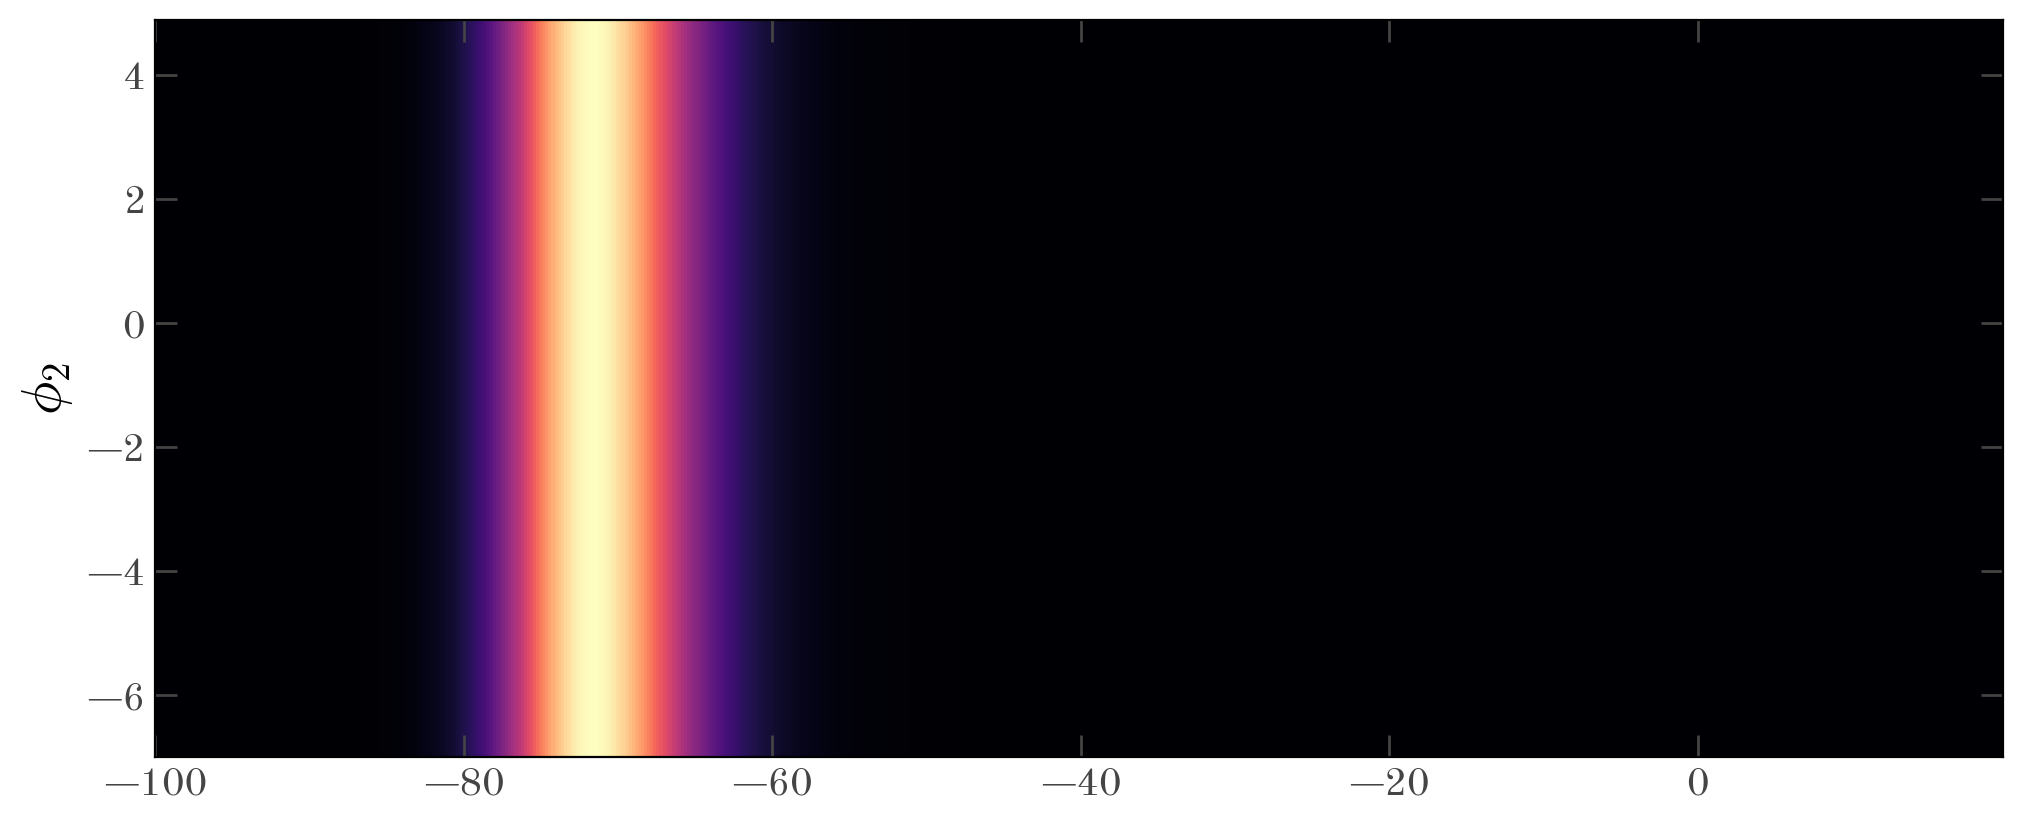

In [7]:
background.plot_model_projections()

## Stream model

In [8]:
prior = Predictive(GD1StreamModel.setup_numpyro, num_samples=2)
prior_samples = prior(jax.random.PRNGKey(0))
prior_samples

{'ln_n0_stream': DeviceArray([[ 4.40251276,  0.33979878, -3.84364948,  4.97369924,
               -1.93655024,  3.47585341, -0.50308008,  5.40567458,
                4.31906888, -4.56319561,  2.94602979,  7.88042205,
                4.29109256, -4.85272345,  5.33085071,  2.96265692,
                1.4810928 ,  7.50821159,  3.971156  ,  1.18490829,
               -4.222831  ,  7.41375592,  3.97113361,  7.75838757,
               -4.86371333, -1.34757037,  2.13366686, -1.8570461 ,
                0.06600261, -1.22592961,  5.4238205 ,  2.11821515,
               -3.91776797],
              [-4.22755515, -4.59005092,  2.52342315,  4.75975877,
                2.76143293, -3.95556824, -1.52038816, -2.73230468,
                5.74783854, -2.54285541, -0.69150982,  2.36043292,
                0.95742842, -4.19684719, -4.30661442, -0.12548336,
               -0.76867154,  1.23501539,  3.22316889, -2.94949164,
               -3.48038346,  4.44767755, -3.64571641,  6.02719596,
                1

In [9]:
stream_prior_pars = GD1StreamModel.unpack_params({k: v[1] for k, v in prior_samples.items()})
stream = GD1StreamModel(stream_prior_pars)
stream.ln_likelihood(gd1_data)

DeviceArray(-220526.07164385, dtype=float64)

(<Figure size 1000x400 with 1 Axes>,
 array([<AxesSubplot: ylabel='$\\phi_2$'>], dtype=object))

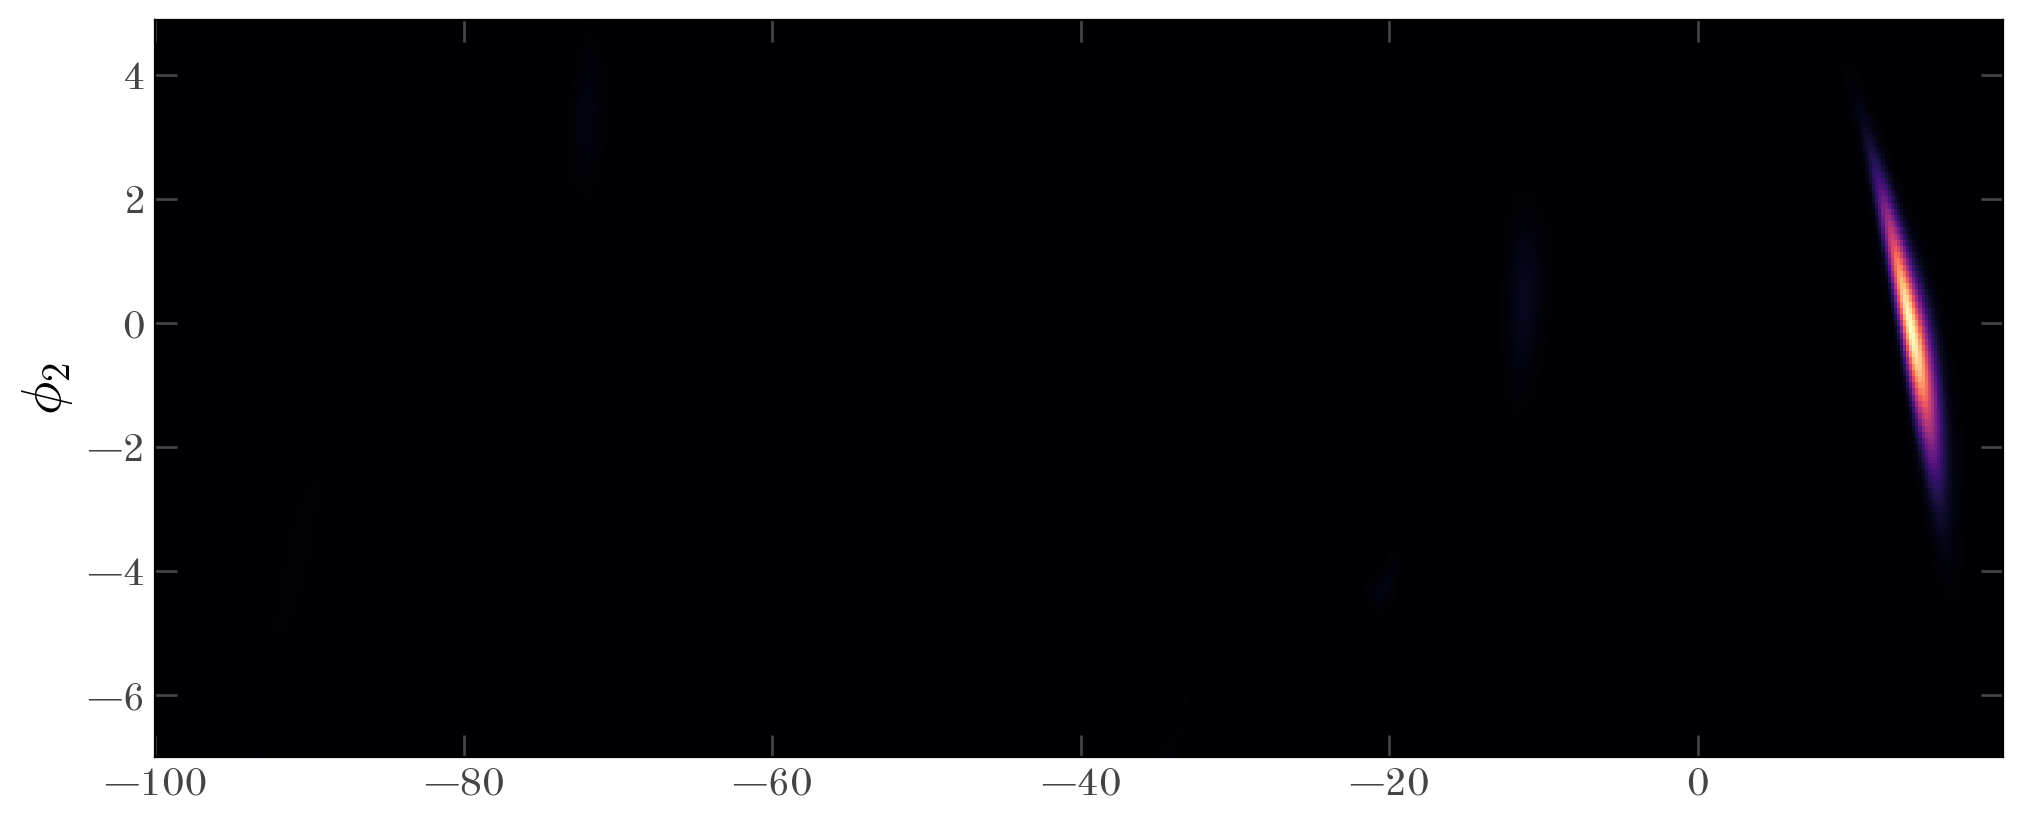

In [10]:
stream.plot_model_projections()

## Mixture model

In [11]:
mixture_model = SplineDensityMixtureModel([background, stream])

(<Figure size 1000x400 with 1 Axes>,
 array([<AxesSubplot: ylabel='$\\phi_2$'>], dtype=object))

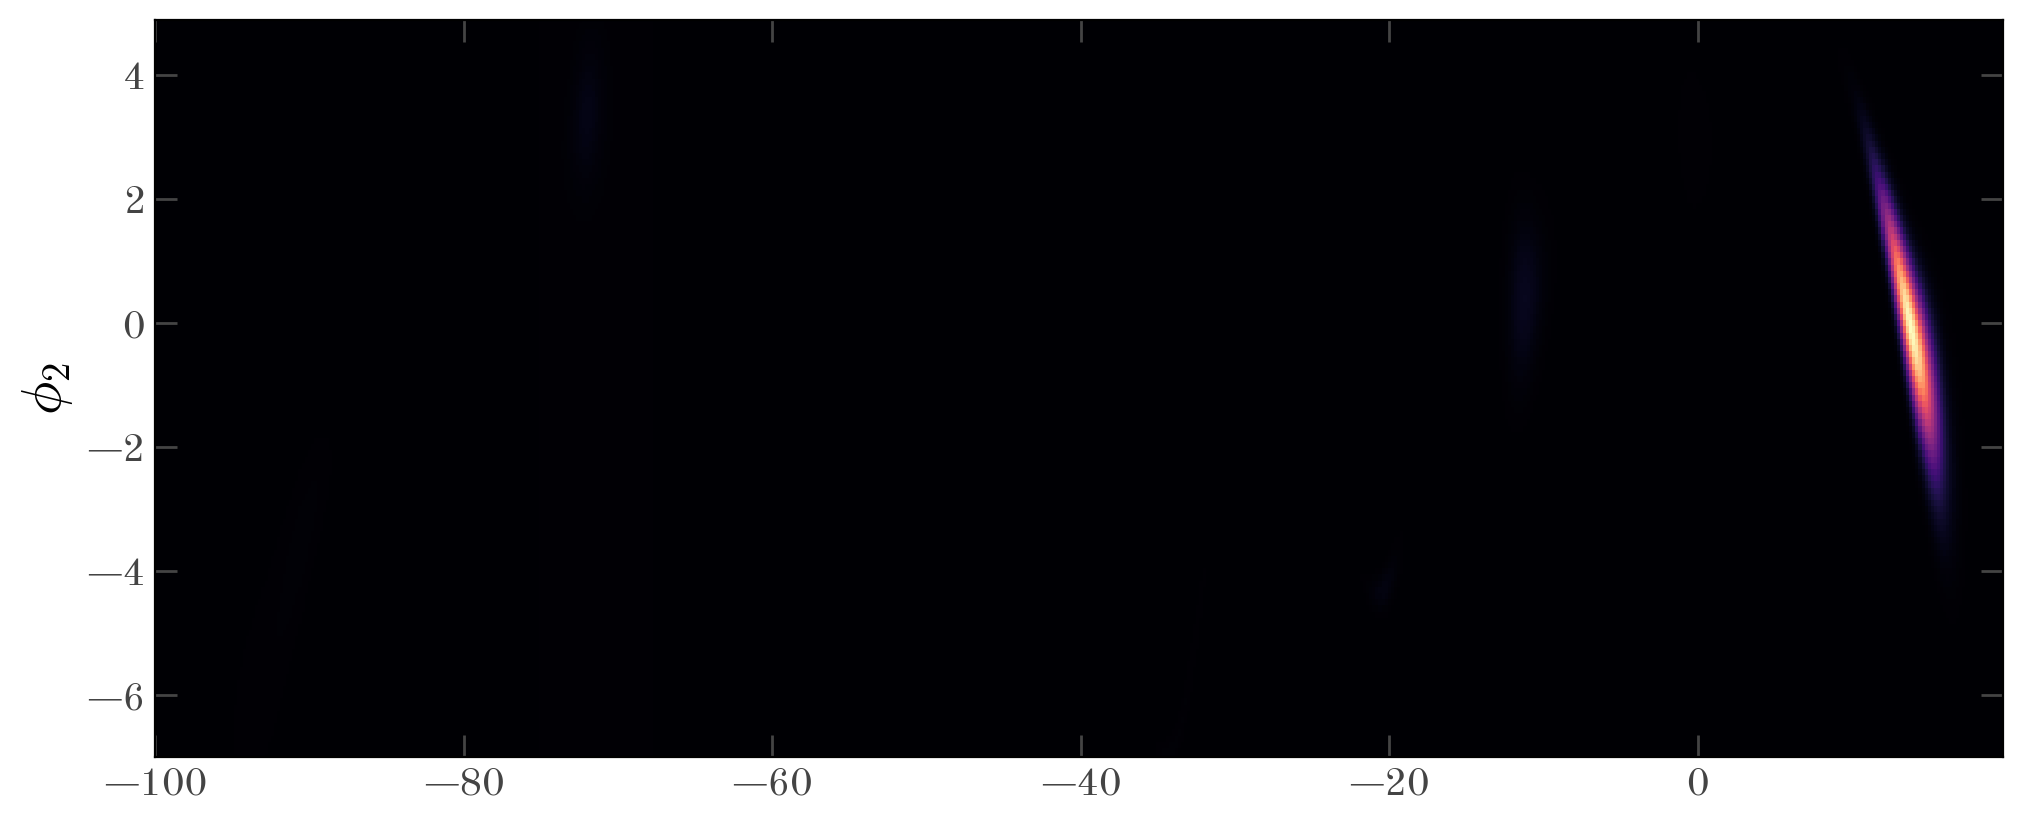

In [12]:
mixture_model.plot_model_projections()

In [13]:
# mixture_model.get_dists(gd1_data)
# pars = {
#     'background': background_prior_pars,
#     'stream': stream_prior_pars
# }
# grids, vals = mixture_model.evaluate_on_grids(pars)

# Initialization:

Text(0.5, 0, '$\\phi_1$')

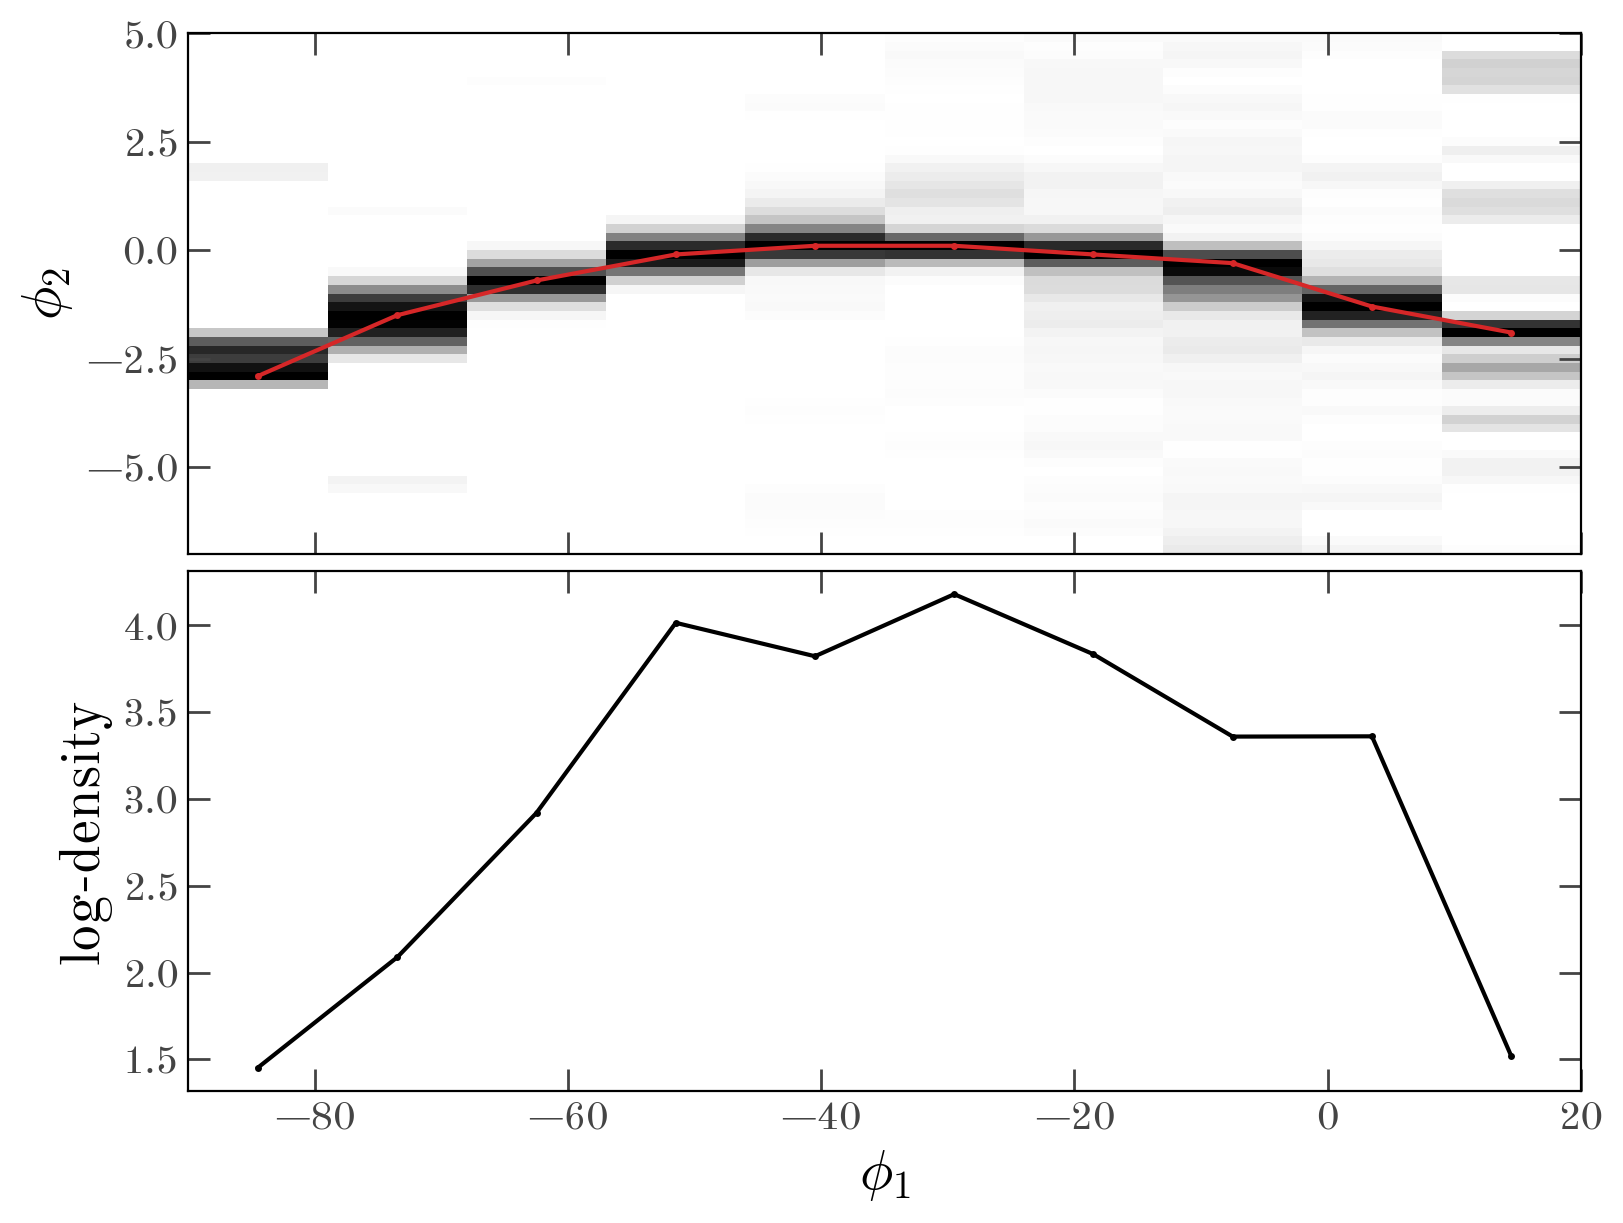

In [14]:
from scipy.ndimage import gaussian_filter1d

H, xe, ye = np.histogram2d(
    gd1_tbl["gd1_phi1"],
    gd1_tbl["gd1_phi2"],
    bins=(np.linspace(-90, 20 + 1e-3, 11), np.arange(-7, 5 + 1e-3, 0.2)),
)
xc = 0.5 * (xe[:-1] + xe[1:])
yc = 0.5 * (ye[:-1] + ye[1:])

H = gaussian_filter1d(H, sigma=1)
H -= np.mean(H[:, (yc < -5) | (yc > 3)])

H /= (xe[1] - xe[0]) / 12
H_density = H.copy()

peak_idx = H.argmax(axis=1)
H /= H[np.arange(H.shape[0]), peak_idx][:, None]
H_ln_density = np.log(H_density[np.arange(H.shape[0]), peak_idx])


fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True, constrained_layout=True)
cs = axes[0].pcolormesh(xe, ye, H.T, vmin=0, vmax=1, cmap="Greys")
axes[0].plot(xc, yc[peak_idx], color="tab:red")
axes[0].set_ylabel(r"$\phi_2$")
axes[1].plot(xc, H_ln_density)
axes[1].set_ylabel(r"log-density")
axes[1].set_xlabel(r"$\phi_1$")

In [15]:
init_ln_n0 = sci.InterpolatedUnivariateSpline(xc, H_ln_density, k=1)(GD1StreamModel.knots['ln_n0'])
init_mean_phi2 = sci.InterpolatedUnivariateSpline(xc, yc[peak_idx], k=1)(GD1StreamModel.knots['phi2'])

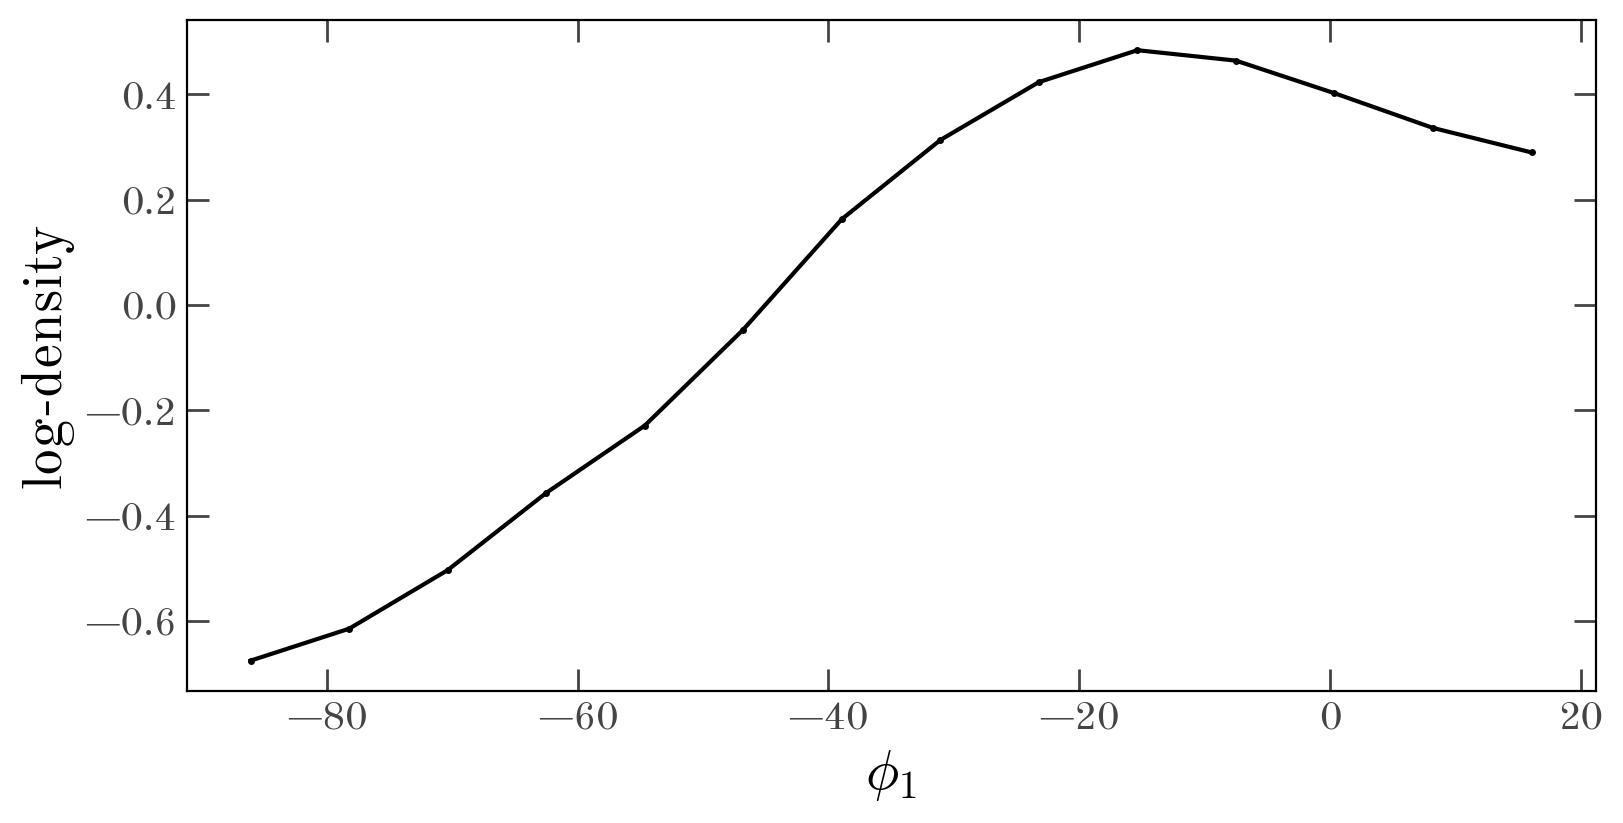

In [16]:
_mask = (gd1_tbl["gd1_phi2"] > 3) | (gd1_tbl["gd1_phi2"] < -5)
H, xe = np.histogram(gd1_tbl["gd1_phi1"][_mask], bins=np.linspace(-90, 20 + 1e-3, 15))
xc = 0.5 * (xe[:-1] + xe[1:])

dx = xe[1] - xe[0]
H = np.log(gaussian_filter1d(H, sigma=2) / dx / 4)

fig, ax = plt.subplots(figsize=(8, 4), constrained_layout=True)
ax.plot(xc, H)
ax.set_ylabel(r"log-density")
ax.set_xlabel(r"$\phi_1$")

init_ln_n0_bkg = sci.InterpolatedUnivariateSpline(xc, H, k=1)(GD1BackgroundModel.knots['ln_n0'])

In [17]:
init_pars = {
    "stream": {
        "ln_n0": init_ln_n0,
        "phi2": {
            "mean": init_mean_phi2,
            "ln_std": np.full_like(init_mean_phi2, -0.75)
        }
    },
    "background": {
        "ln_n0": init_ln_n0_bkg,
    }
}

Components = [GD1StreamModel, GD1BackgroundModel]
init_pars["stream"] = GD1StreamModel.clip_params(init_pars["stream"])
init_pars["background"] = GD1BackgroundModel.clip_params(init_pars["background"])

(<Figure size 1200x600 with 4 Axes>,
 array([[<AxesSubplot: title={'center': 'stream'}, ylabel='ln_n0'>,
         <AxesSubplot: title={'center': 'background'}, ylabel='ln_n0'>],
        [<AxesSubplot: ylabel='phi2'>, <AxesSubplot: ylabel='phi2'>]],
       dtype=object))

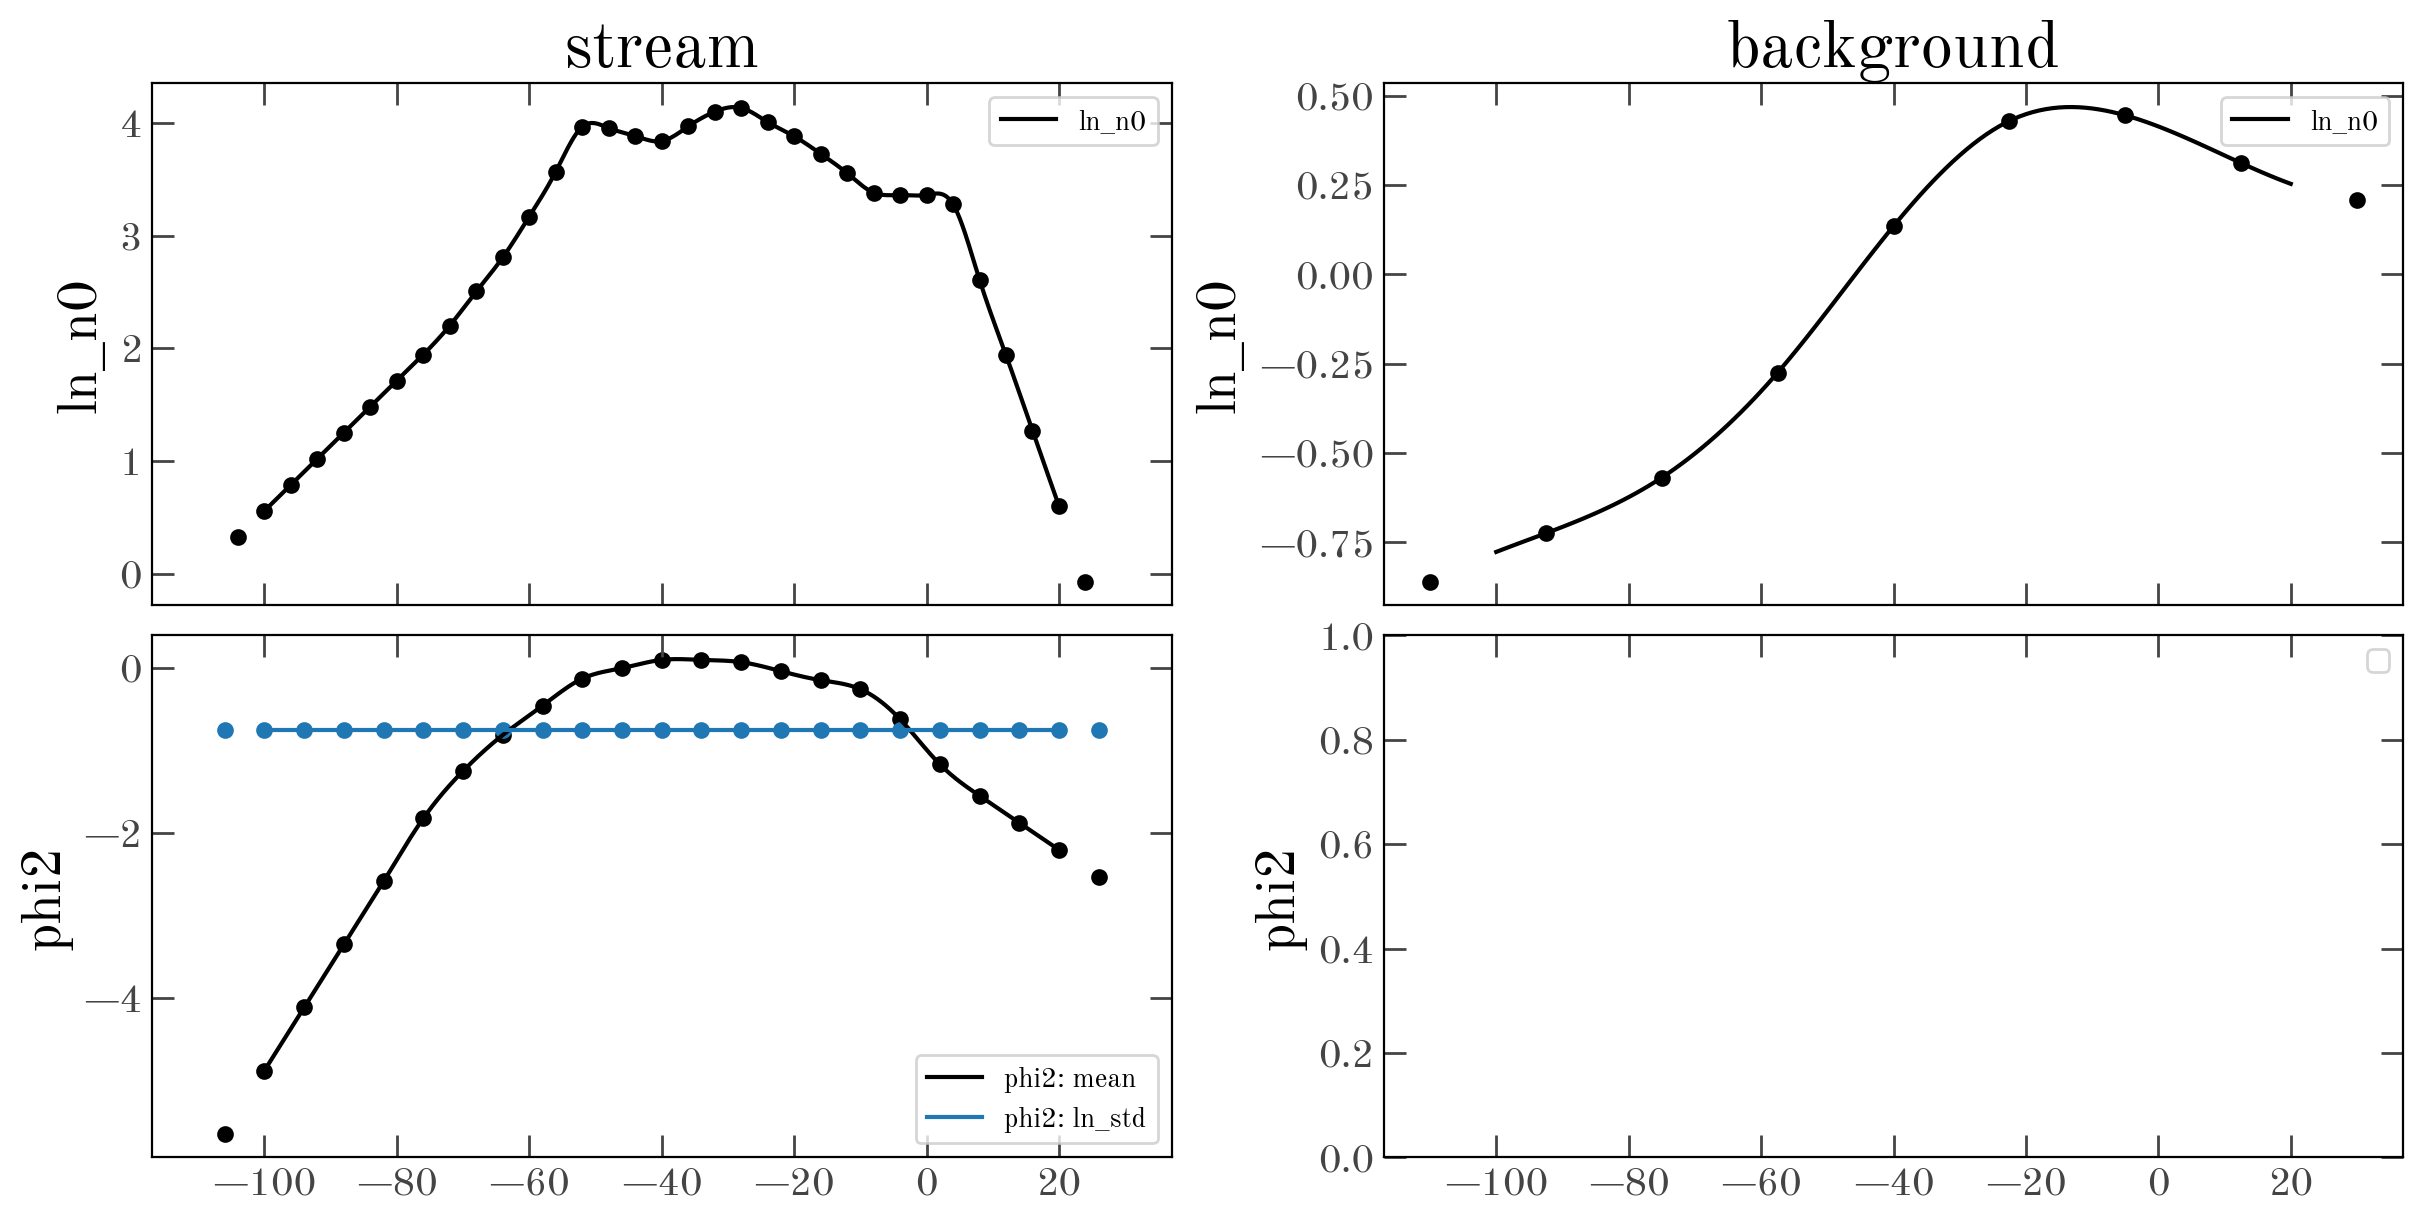

In [18]:
init_mixture = SplineDensityMixtureModel([C(init_pars[C.name]) for C in Components])
init_mixture.plot_knots()

In [19]:
joint_optimize = optimize(
    SplineDensityMixtureModel.setup_numpyro, 
    start=init_pars,
    return_info=True
)
opt_pars, info = joint_optimize(
    jax.random.PRNGKey(0), 
    Components=Components, 
    data=gd1_data
)

In [20]:
info
assert info.success

In [21]:
opt_pars_unpacked = SplineDensityMixtureModel.unpack_params(opt_pars, Components)
opt_mixture = SplineDensityMixtureModel([C(opt_pars_unpacked[C.name]) for C in Components])
# opt_pars_unpacked

(<Figure size 1000x400 with 1 Axes>,
 array([<AxesSubplot: ylabel='$\\phi_2$'>], dtype=object))

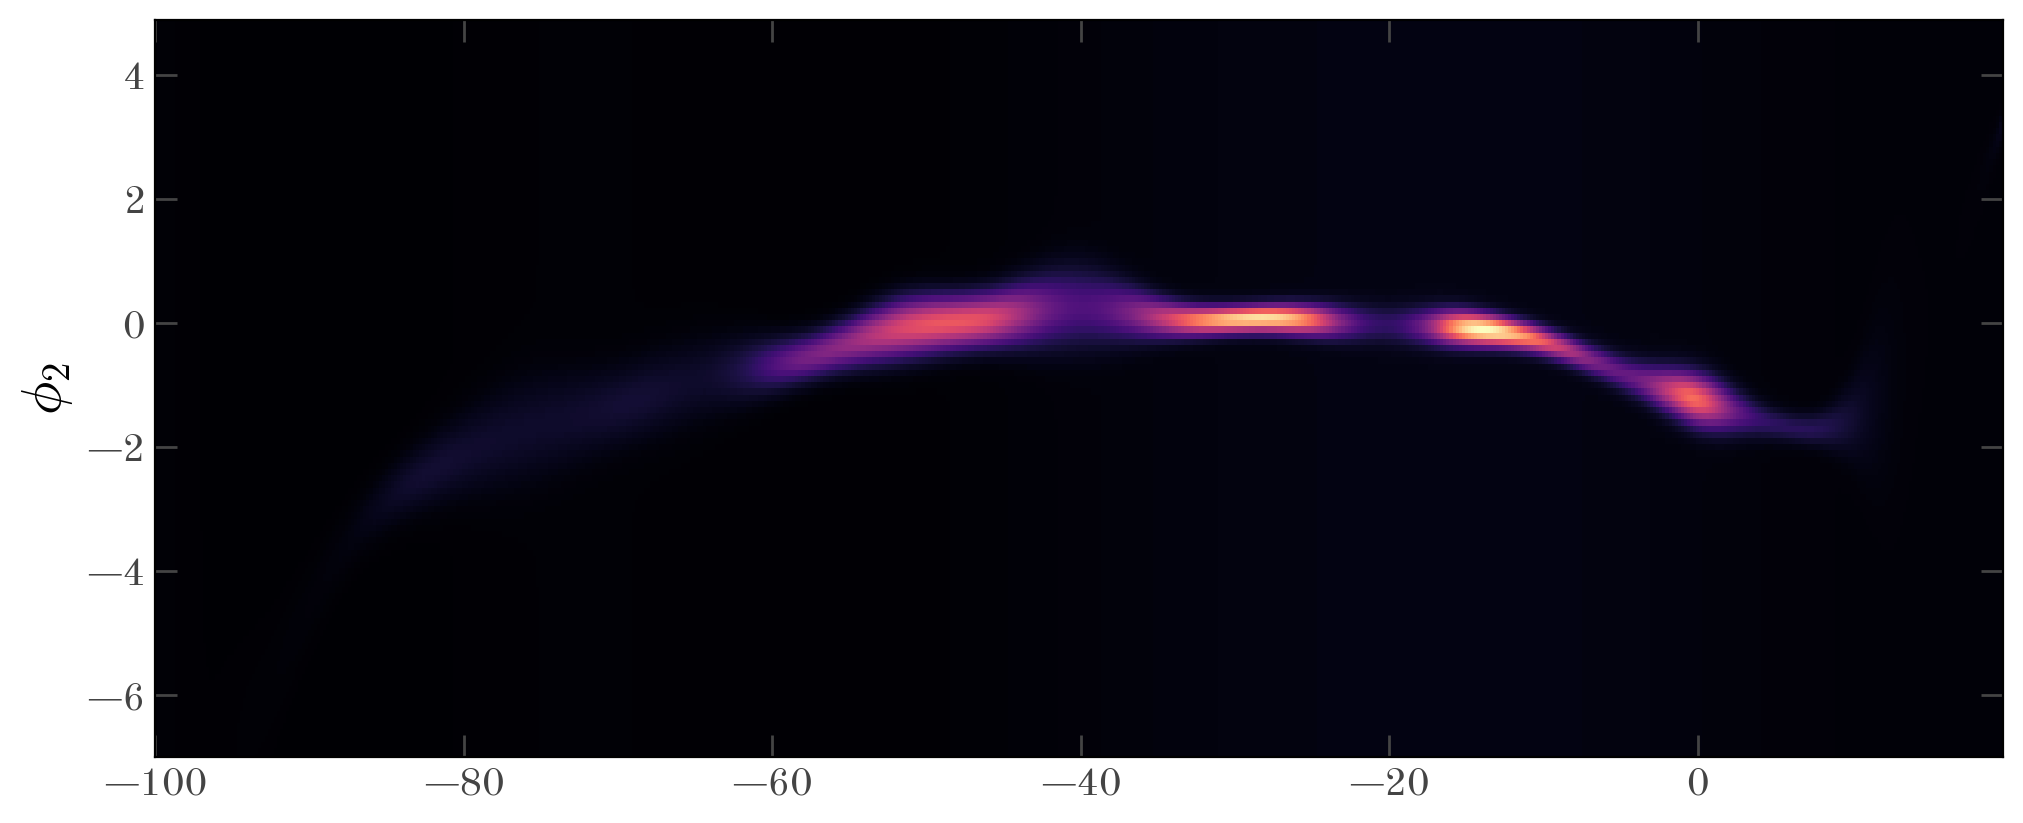

In [22]:
opt_mixture.plot_model_projections()

(<Figure size 1200x600 with 4 Axes>,
 array([[<AxesSubplot: title={'center': 'stream'}, ylabel='ln_n0'>,
         <AxesSubplot: title={'center': 'background'}, ylabel='ln_n0'>],
        [<AxesSubplot: ylabel='phi2'>, <AxesSubplot: ylabel='phi2'>]],
       dtype=object))

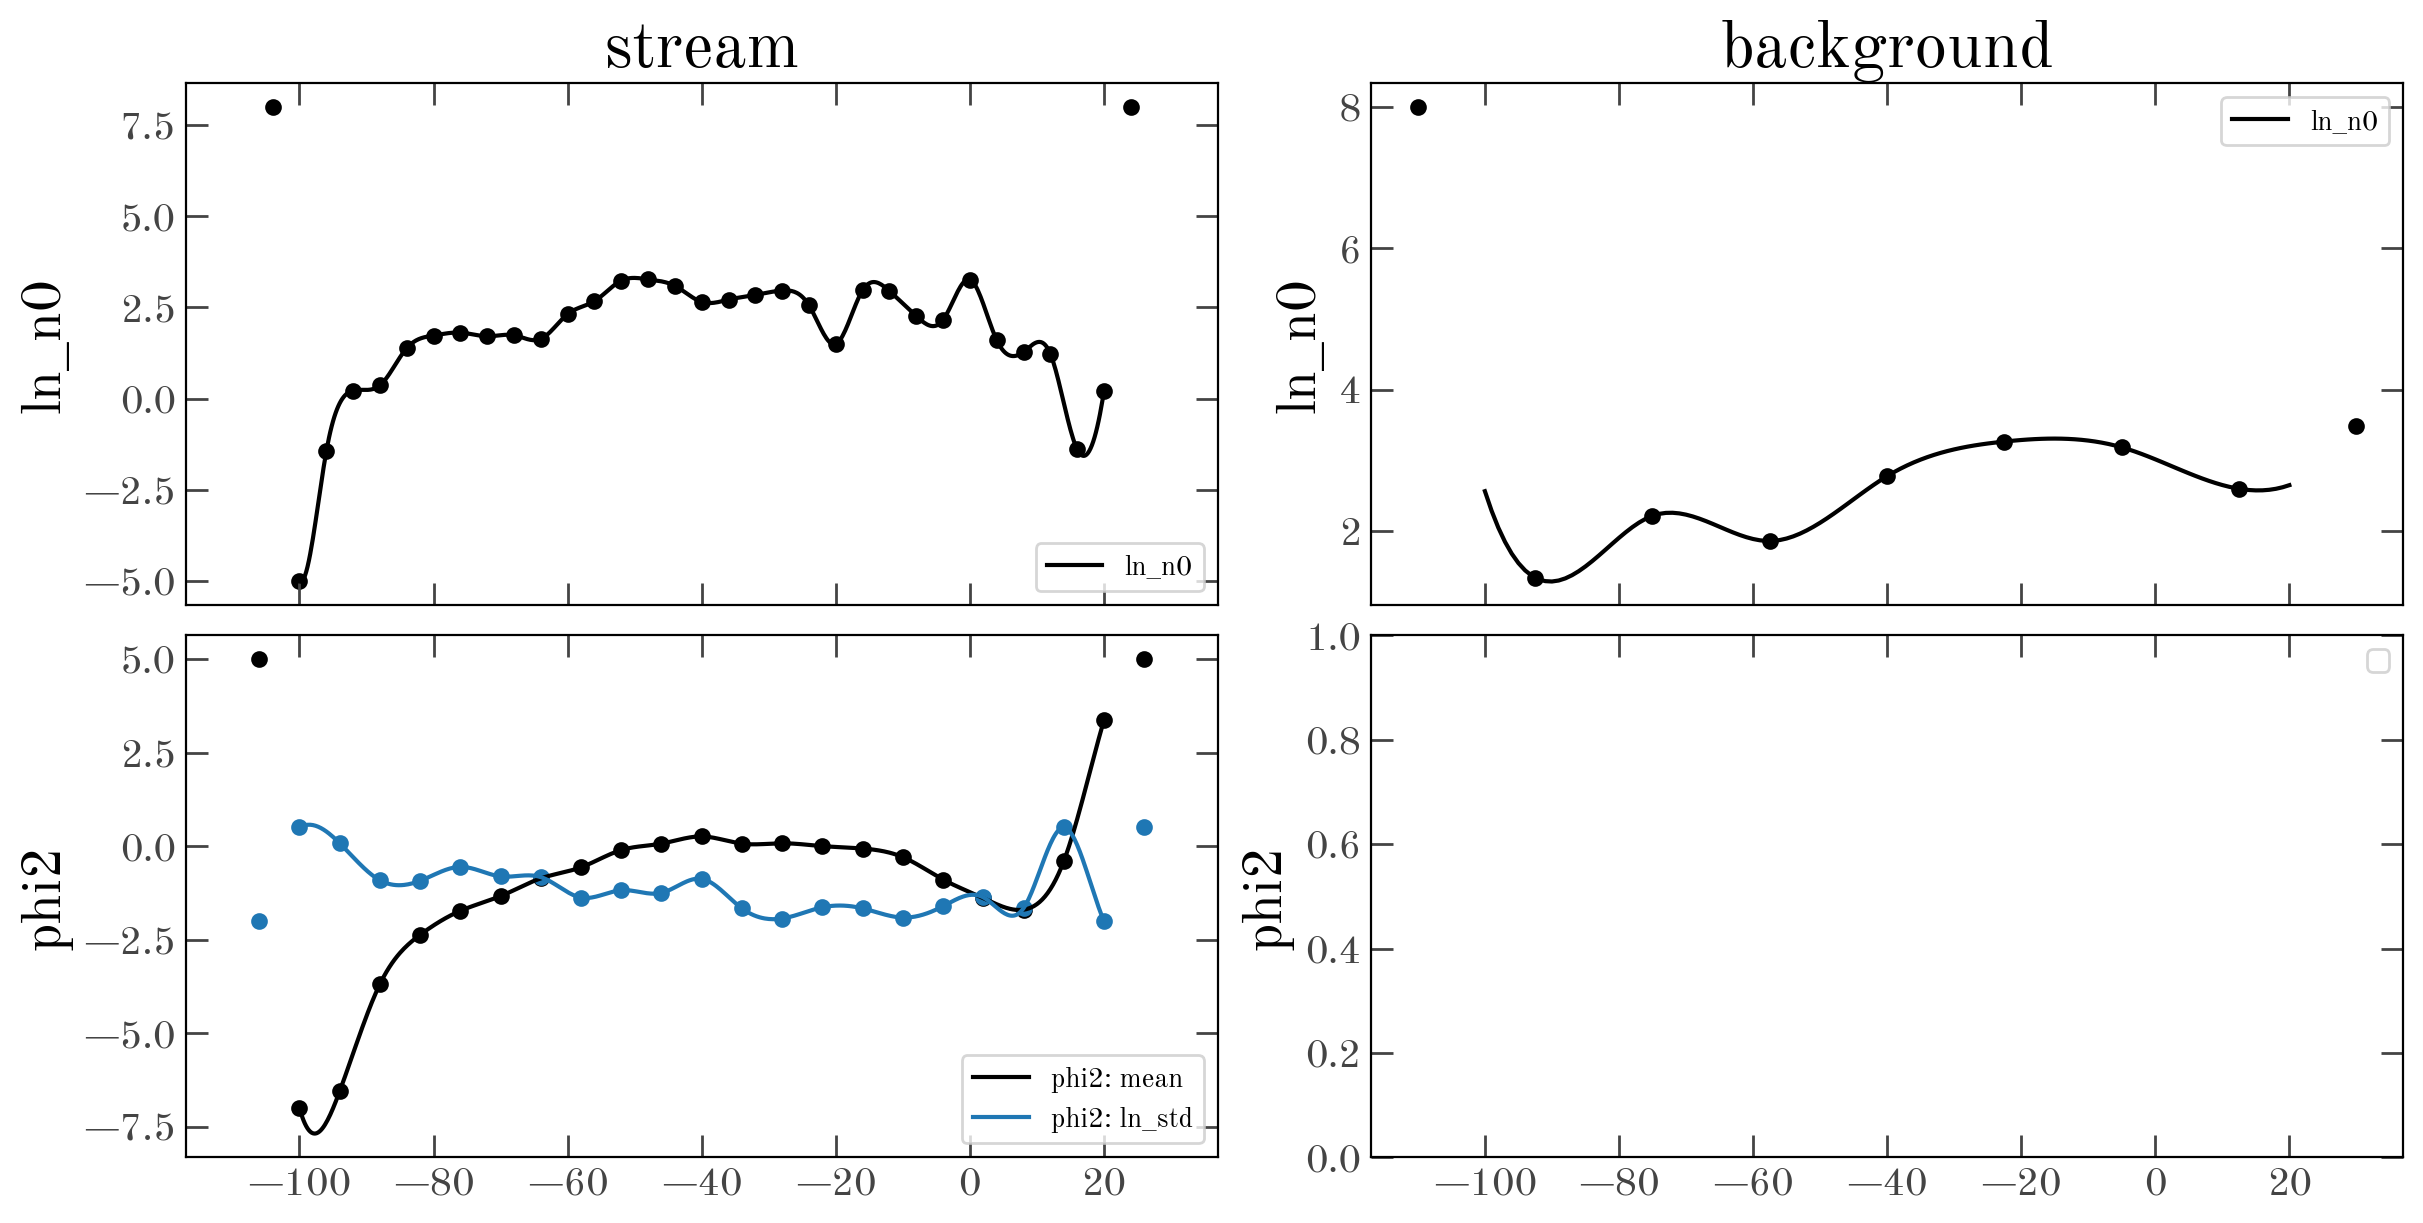

In [23]:
opt_mixture.plot_knots()

In [24]:
rng = np.random.default_rng(seed=42)

n_chains = 2

init_pars_chains = {}
for C in Components:
    C_pars = init_pars[C.name]
    
    sub = {}
    tmp = C_pars[C.density_name]
    sub[C.density_name] = rng.normal(tmp, 1e-2, size=(n_chains, len(tmp)))
    
    for coord_name in C.coord_names:
        if coord_name not in sub:
            if coord_name not in C_pars or not C_pars[coord_name]:
                continue
            sub[coord_name] = {}
        
        for par_name, tmp in C_pars[coord_name].items():
            sub[coord_name][par_name] = rng.normal(tmp, 1e-2, size=(n_chains, len(tmp)))
    
    init_pars_chains[C.name] = sub

In [25]:
mcmc_kw = dict(
    num_warmup=100,
    num_samples=100,
    num_chains=n_chains,
    chain_method="sequential",
)

mcmc = MCMC(NUTS(SplineDensityMixtureModel.setup_numpyro), **mcmc_kw)
mcmc.run(
    jax.random.PRNGKey(0), 
    Components=Components,
    data=gd1_data,
    init_params=init_pars_chains
)

sample: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [02:08<00:00,  1.56it/s, 255 steps of size 2.09e-02. acc. prob=0.95]


In [30]:
mcmc.print_summary()


                            mean       std    median      5.0%     95.0%     n_eff     r_hat
   ln_n0_background[0]      3.56      1.23      3.53      1.92      5.79    382.92      1.00
   ln_n0_background[1]      1.62      0.11      1.63      1.45      1.81    364.28      1.00
   ln_n0_background[2]      2.11      0.11      2.12      1.95      2.31    600.81      1.00
   ln_n0_background[3]      1.92      0.10      1.93      1.74      2.07    481.14      1.00
   ln_n0_background[4]      2.75      0.07      2.76      2.63      2.86    452.46      0.99
   ln_n0_background[5]      3.28      0.06      3.28      3.19      3.37    529.99      0.99
   ln_n0_background[6]      3.16      0.05      3.16      3.08      3.25    451.38      1.00
   ln_n0_background[7]      2.62      0.09      2.63      2.49      2.76    325.96      1.00
   ln_n0_background[8]      3.09      0.86      3.11      1.60      4.39    234.07      1.00
       ln_n0_stream[0]      1.62      3.90      1.49     -3.97      7

In [31]:
samples = mcmc.get_samples()
samples_unpacked = SplineDensityMixtureModel.unpack_params(samples, Components)

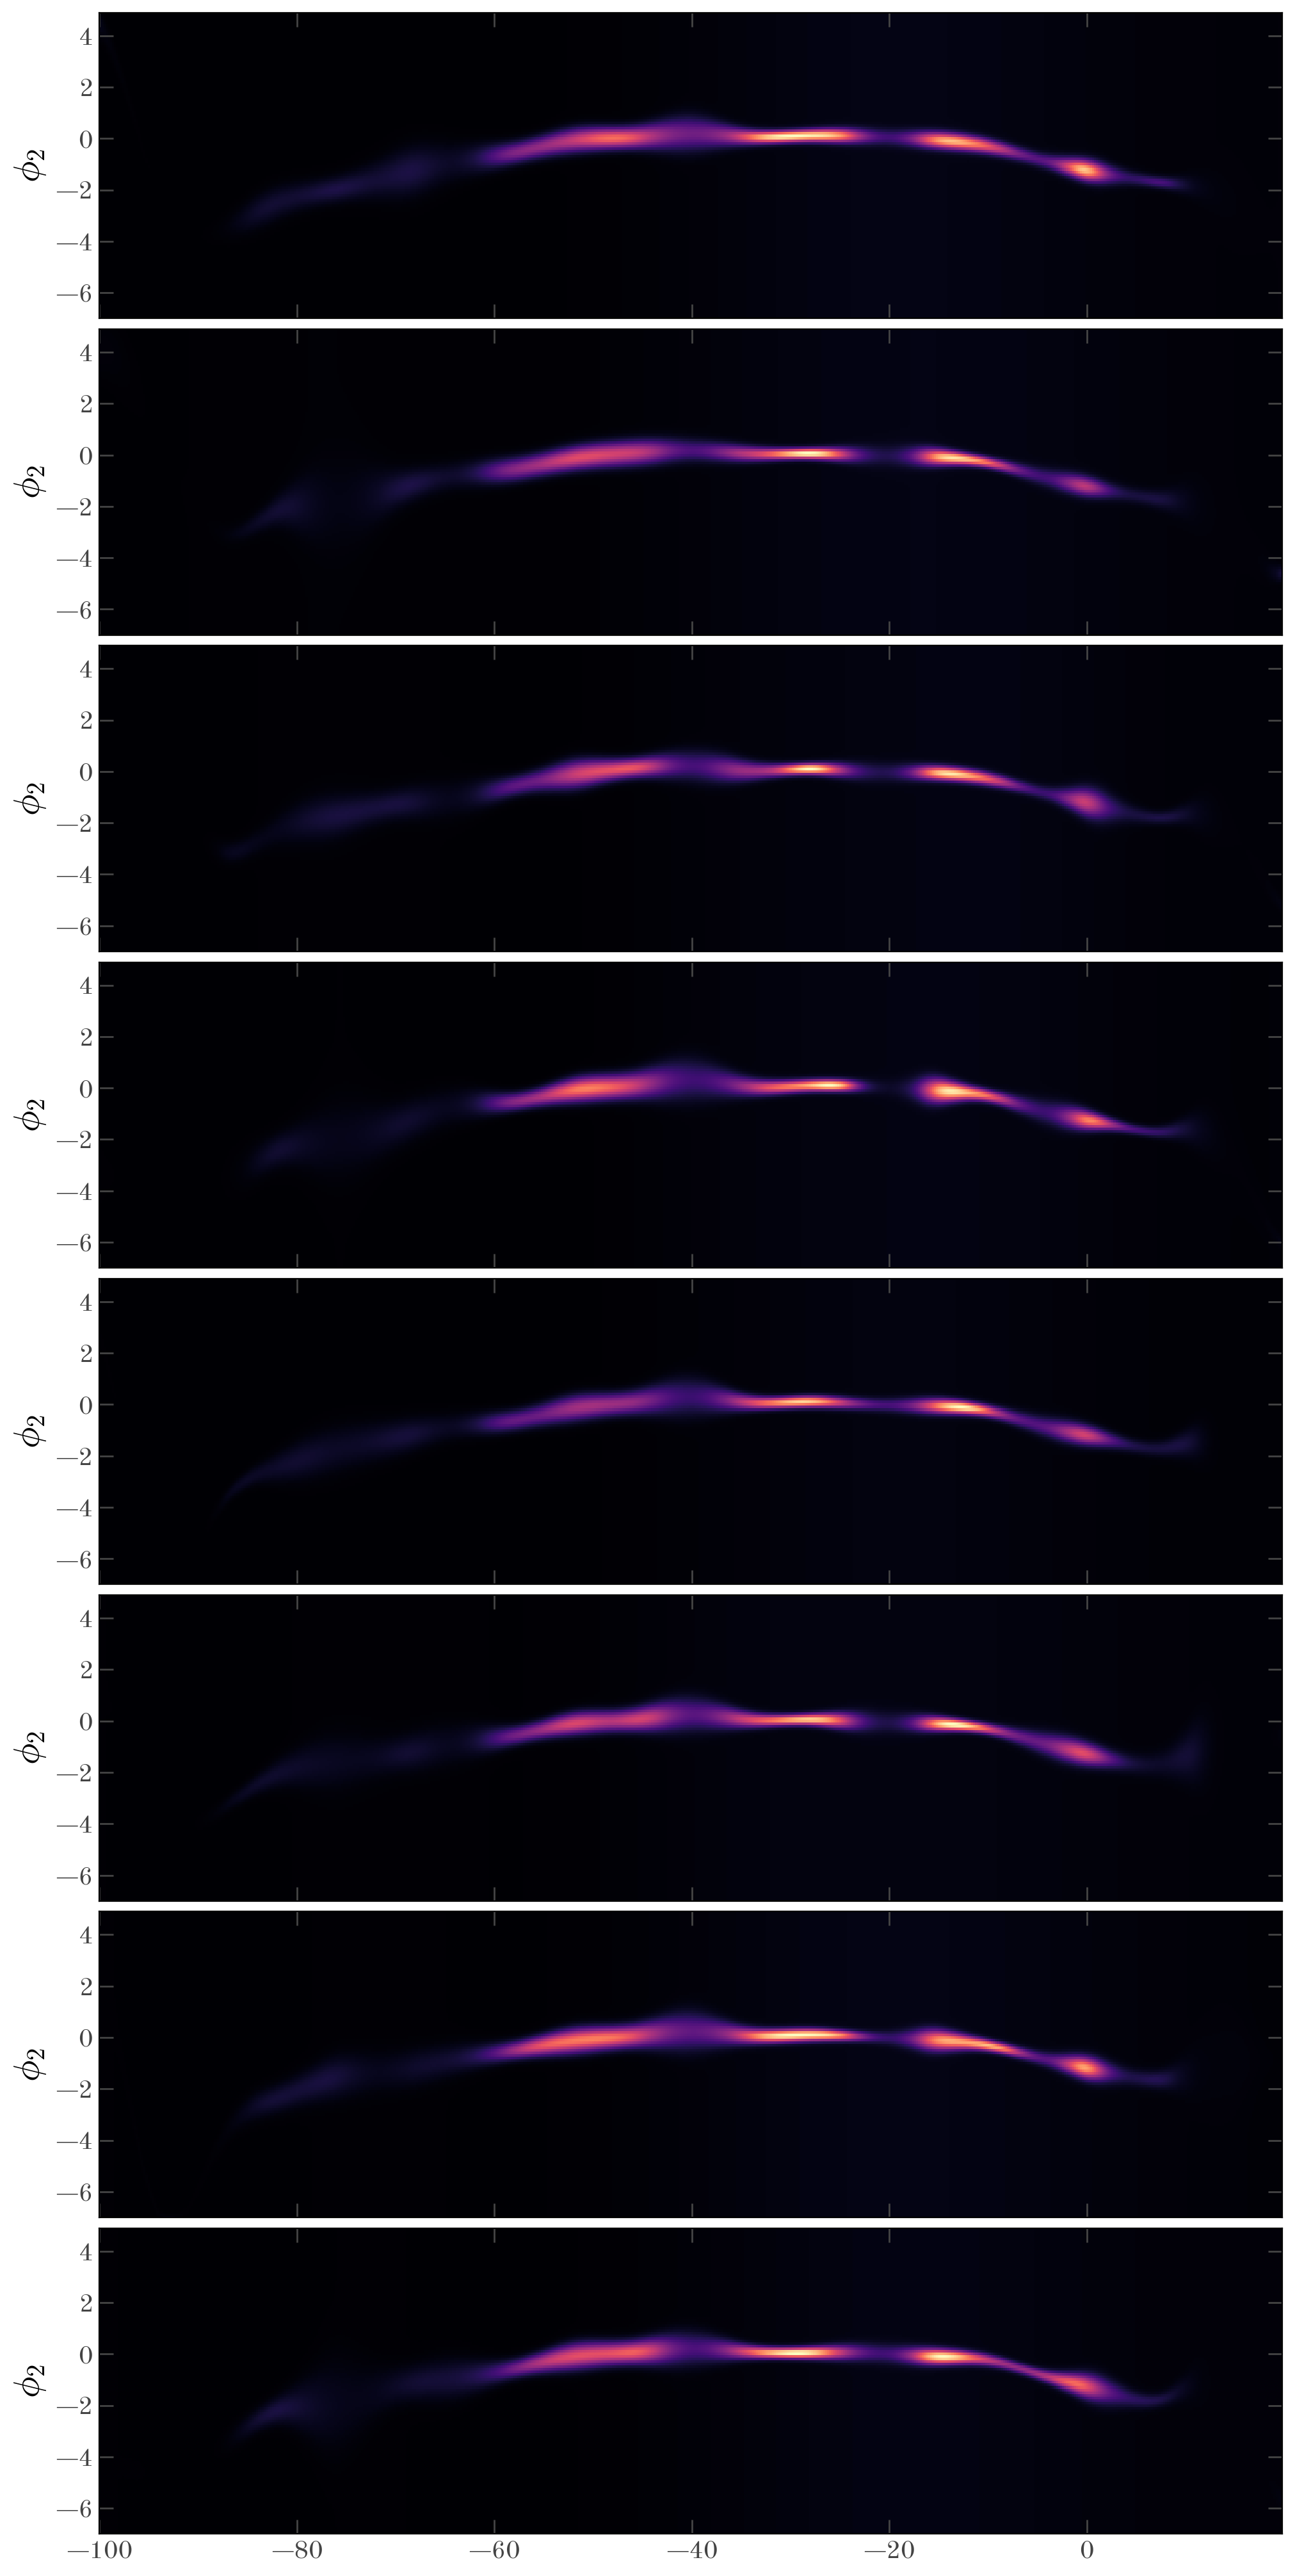

In [32]:
nsamples = 8
fig, axes = plt.subplots(
    nsamples, 1, figsize=(10, nsamples * 2.5), sharex=True, sharey=True, constrained_layout=True
)

rng = np.random.default_rng(32)
for j, i in enumerate(rng.choice(samples['ln_n0_background'].shape[0], size=nsamples)):
    sample_unpacked = SplineDensityMixtureModel.unpack_params(
        {k: v[i] for k, v in samples.items()}, 
        Components
    )
    sample_mixture = SplineDensityMixtureModel([C(sample_unpacked[C.name]) for C in Components])
    sample_mixture.plot_model_projections(axes=np.array([axes[j]]))

(<Figure size 1200x600 with 4 Axes>,
 array([[<AxesSubplot: title={'center': 'stream'}, ylabel='ln_n0'>,
         <AxesSubplot: title={'center': 'background'}, ylabel='ln_n0'>],
        [<AxesSubplot: ylabel='phi2'>, <AxesSubplot: ylabel='phi2'>]],
       dtype=object))

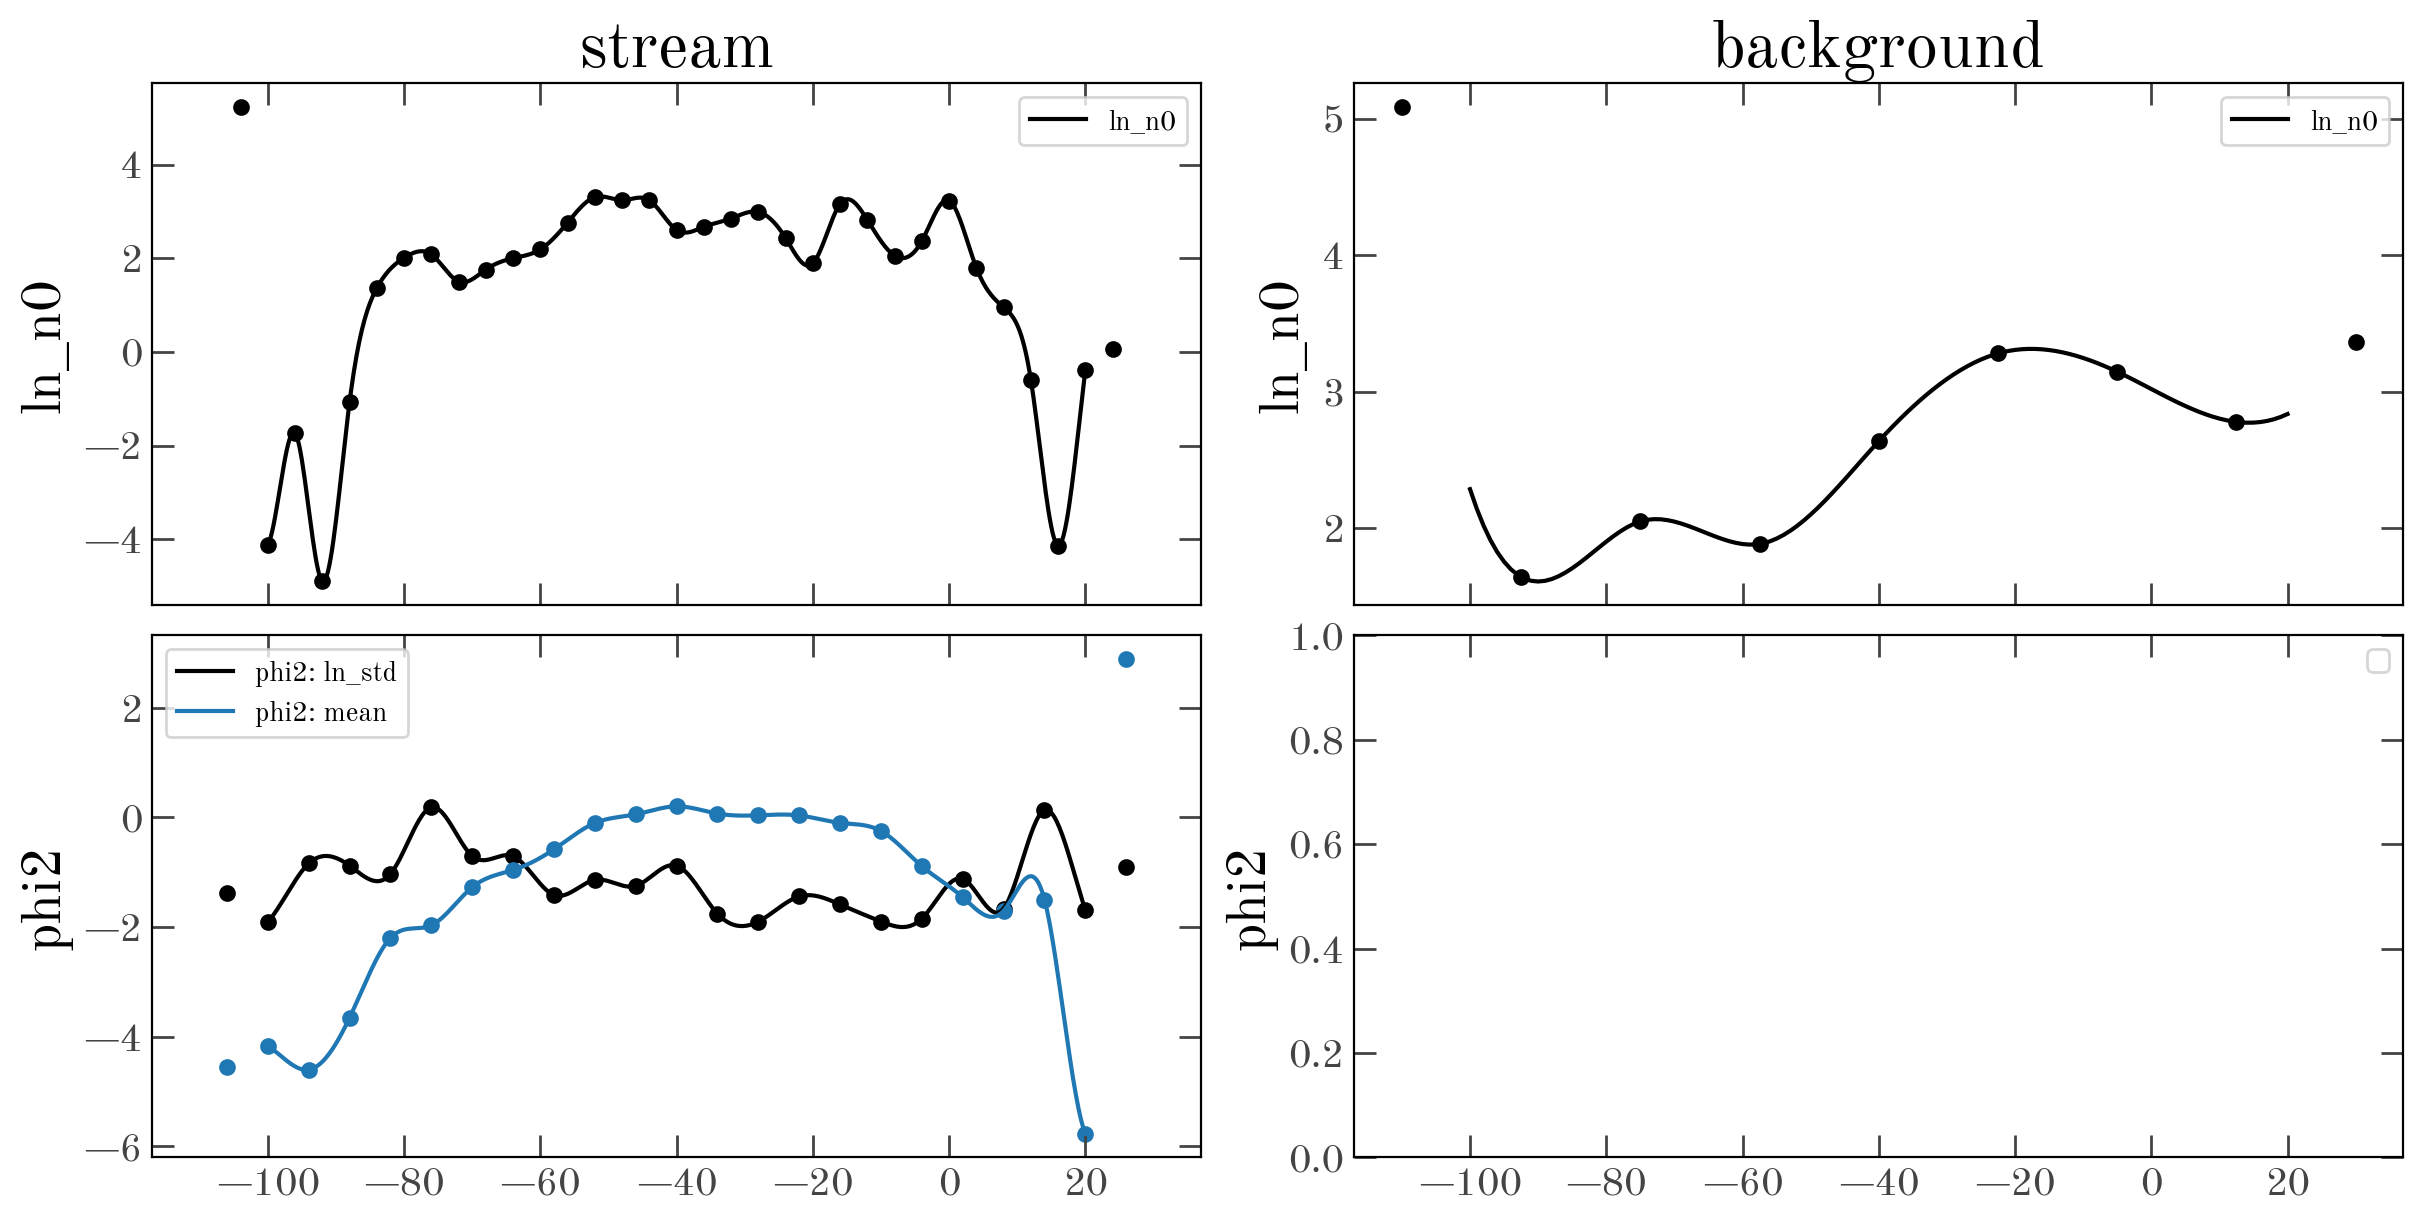

In [29]:
sample_mixture.plot_knots()